In [1]:
import cv2
from darkflow.net.build import TFNet
import numpy as np
import time
from time import time as timer

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

/home/cesare/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
option = {
    'model': 'cfg/yolo.cfg',
    'load': 'bin/yolo.weights',
    'threshold': 0.25,
    'gpu': 0.0
}

tfnet = TFNet(option)

Parsing ./cfg/yolo.cfg
Parsing cfg/yolo.cfg
Loading bin/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.04360485076904297s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!

# Processing Images (1)

In [3]:
# read the color image and covert to RGB

#img = cv2.imread('eagle.jpg', cv2.IMREAD_COLOR)
img = cv2.imread('dog.jpg', cv2.IMREAD_COLOR)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# use YOLO to predict the image
result = tfnet.return_predict(img)

result

[{'bottomright': {'x': 550, 'y': 462},
  'confidence': 0.79921085,
  'label': 'bicycle',
  'topleft': {'x': 85, 'y': 115}},
 {'bottomright': {'x': 698, 'y': 168},
  'confidence': 0.8184496,
  'label': 'truck',
  'topleft': {'x': 461, 'y': 82}},
 {'bottomright': {'x': 326, 'y': 534},
  'confidence': 0.8198157,
  'label': 'dog',
  'topleft': {'x': 130, 'y': 215}}]

In [4]:
img.shape

(576, 768, 3)

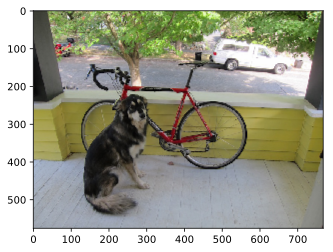

In [5]:
plt.imshow(img)
plt.show()

(85, 115)
(550, 462)


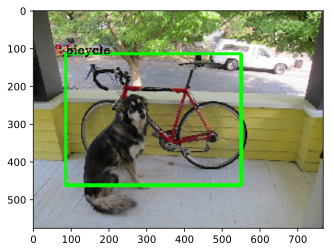

In [6]:
# pull out some info from the results

tl = (result[0]['topleft']['x'], result[0]['topleft']['y'])
print(tl)
br = (result[0]['bottomright']['x'], result[0]['bottomright']['y'])
print(br)
label = result[0]['label']

# add the box and label and display it
img = cv2.rectangle(img, tl, br, (0, 255, 0), 7)
img = cv2.putText(img, label, tl, cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
plt.imshow(img)
plt.show()

## Pre-process (a)

Elapsed time = 1.0988857746124268 s


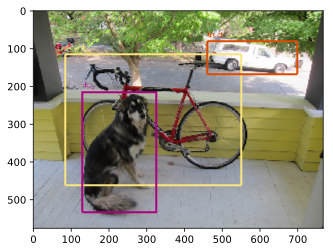

In [7]:
#img = cv2.imread('eagle.jpg', cv2.IMREAD_COLOR)
img = cv2.imread('dog.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#result = tfnet.return_predict(img)

start = timer()

preprocessed = tfnet.framework.preprocess(img)
feed_dict = {tfnet.inp: [preprocessed]}
net_out = tfnet.sess.run(tfnet.out,feed_dict)[0]

processed = tfnet.framework.postprocess(net_out, img, False)

cv2.imwrite('out_dog.jpg', processed)
print('Elapsed time = ' + str(timer() - start) + ' s')

'''
fig = plt.figure(1)
fig.gca().imshow(processed)
plt.show()
'''

plt.imshow(processed)
plt.show()

## Pre-process (b)

Elapsed time = 1.1030616760253906 s


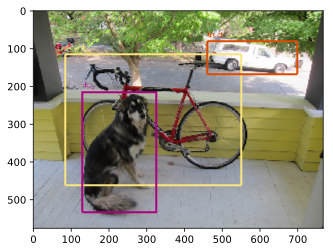

In [8]:
#img = cv2.imread('eagle.jpg', cv2.IMREAD_COLOR)
img = cv2.imread('dog.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#result = tfnet.return_predict(img)

start = timer()

buffer_inp = list()
buffer_pre = list()
    
preprocessed = tfnet.framework.preprocess(img)

buffer_inp.append(img)
buffer_pre.append(preprocessed)

feed_dict = {tfnet.inp: buffer_pre}
net_out = tfnet.sess.run(tfnet.out,feed_dict)[0]

processed = tfnet.framework.postprocess(net_out, img, False)

cv2.imwrite('out_dog.jpg', processed)
print('Elapsed time = ' + str(timer() - start) + ' s')

'''
fig = plt.figure(1)
fig.gca().imshow(processed)
plt.show()
'''

plt.imshow(processed)
plt.show()

## Pre-process (c)

[]
Elapsed time = 1.10349440574646 s


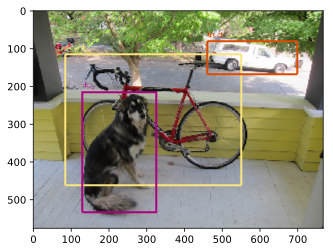

In [9]:
#img = cv2.imread('eagle.jpg', cv2.IMREAD_COLOR)
img = cv2.imread('dog.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#result = tfnet.return_predict(img)

start = timer()

h, w, _ = img.shape

'''
img = tfnet.framework.resize_input(img)
this_inp = np.expand_dims(img, 0)
feed_dict = {tfnet.inp : this_inp}
'''

preprocessed = tfnet.framework.preprocess(img)
feed_dict = {tfnet.inp: [preprocessed]}

net_out = tfnet.sess.run(tfnet.out, feed_dict)[0]
processed = tfnet.framework.postprocess(net_out, img, False)

###############
# Boxes Info  #
###############
boxes = tfnet.framework.findboxes(net_out)

threshold = 0.25

boxesInfo = list()
#
for box in boxes:
    tmpBox = tfnet.framework.process_box(box, h, w, threshold)
    if tmpBox is None:
        continue
    boxesInfo.append({
        "label": tmpBox[4],
        "confidence": tmpBox[6],
        "topleft": {
            "x": tmpBox[0],
            "y": tmpBox[2]},
        "bottomright": {
            "x": tmpBox[1],
            "y": tmpBox[3]}
    })
#
print(boxesInfo)
#

cv2.imwrite('out_dog.jpg', processed)
print('Elapsed time = ' + str(timer() - start) + ' s')

plt.imshow(processed)
plt.show()

# Processing Images (2)

In [10]:
colors = [tuple(255 * np.random.rand(3)) for i in range(7)]  #range(100)

for color in colors:
    print(color)

(44.282294056131036, 208.784286187158, 142.17182135379662)
(167.46011314771366, 168.03965029948773, 8.016206447510278)
(174.50530273556677, 26.45888904273269, 15.69890935606)
(33.51586962111733, 247.24243349506528, 61.51886313539435)
(250.75092406458376, 192.52723591455464, 157.03030920732903)
(70.97266064112573, 158.29155047838694, 74.74350274639733)
(178.50668651352632, 42.7819840524242, 250.65235714050553)


{'bottomright': {'y': 462, 'x': 550}, 'label': 'bicycle', 'topleft': {'y': 115, 'x': 85}, 'confidence': 0.79921085}
{'bottomright': {'y': 168, 'x': 698}, 'label': 'truck', 'topleft': {'y': 82, 'x': 461}, 'confidence': 0.8184496}
{'bottomright': {'y': 534, 'x': 326}, 'label': 'dog', 'topleft': {'y': 215, 'x': 130}, 'confidence': 0.8198157}
FPS 0.9


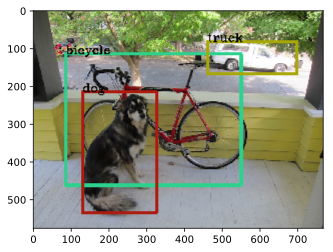

In [11]:
# read the color image and covert to RGB

stime = time.time()
img = cv2.imread('dog.jpg', cv2.IMREAD_COLOR)
#img = cv2.imread('eagle.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = tfnet.return_predict(img)

for color, result in zip(colors, results):
    tl = (result['topleft']['x'], result['topleft']['y'])
    br = (result['bottomright']['x'], result['bottomright']['y'])
    label = result['label']
    img = cv2.rectangle(img, tl, br, color, 7)
    img = cv2.putText(img, label, tl, cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
    print(result)
    
cv2.imshow('img', img)
print('FPS {:.1f}'.format(1 / (time.time() - stime)))  # Frame per seconds

plt.imshow(img)
plt.show()